In [53]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

In [56]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Apps_for_Android_5.json.gz')

In [57]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"


In [58]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of unique products: ", len(list(set(df['asin']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['overall']==3]["reviewText"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['overall']>3]["reviewText"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['overall']<3]["reviewText"].count()/len(df)*100))

Summary statistics of numerical features : 
              overall  unixReviewTime
count  752937.000000    7.529370e+05
mean        3.968931    1.368442e+09
std         1.342484    2.342230e+07
min         1.000000    1.134778e+09
25%         3.000000    1.354147e+09
50%         5.000000    1.370477e+09
75%         5.000000    1.388448e+09
max         5.000000    1.406074e+09

Total number of reviews:  752937

Total number of unique products:  13209

Percentage of reviews with neutral sentiment : 11.31%

Percentage of reviews with positive sentiment : 72.35%

Percentage of reviews with negative sentiment : 16.35%


Text(0, 0.5, 'Count')

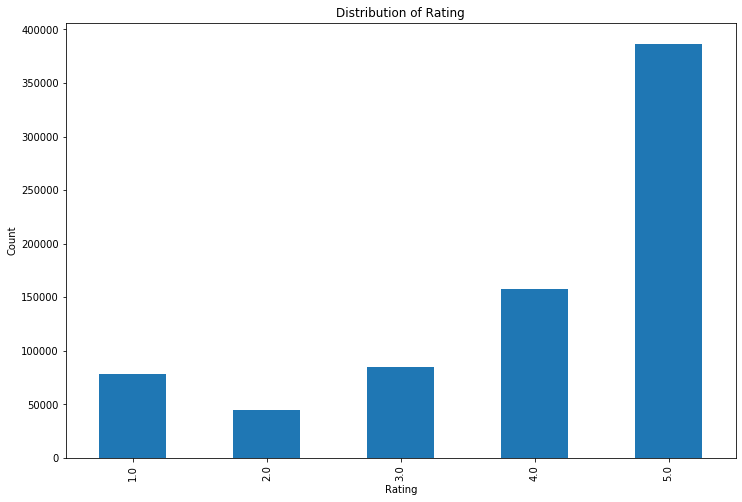

In [59]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

In [60]:
dfs = df.sample(frac=0.01, random_state=0)
#dfs = df

# Drop missing values
dfs.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['overall'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
dfs['Sentiment'] = np.where(dfs['overall'] > 3, 1, 0)
dfs.head(10)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Sentiment
593193,AJOTI18QFM0U9,B00CXBSYVG,Buckleshoe,"[0, 0]",Enjoy playing Bingo Blast a bit slow but it is...,5.0,bingo blast,1391040000,"01 30, 2014",1
226970,A1KYB5V7M5QWUG,B007BUTTSQ,Kidz,"[0, 0]","It's a simple puzzle, easy to do, and doesn't ...",4.0,Beautiful butterflys,1389484800,"01 12, 2014",1
325965,A2NOW4U7W3F7RI,B008CPZNL6,rpv,"[0, 0]",There are several news reading apps - news.goo...,5.0,Good News consumption app,1352937600,"11 15, 2012",1
193367,A1NRIGFSHOH79A,B006PHD0RW,Derby,"[0, 0]",Love this game. Hard and extremely frustratin...,5.0,SO addictive!!!!,1329609600,"02 19, 2012",1
142254,A165JY8H5LURGM,B0064B3QNC,plum0214,"[0, 0]","This is a fun game. It is not for kids,the tit...",4.0,Fun game for adults,1380153600,"09 26, 2013",1
458789,A1I5U9TN1MTJBN,B00A7V0LWE,Rayla J. Larghe,"[1, 1]",Good to have and easy to use. Very good progra...,5.0,English Dictionary & Thesaurus.,1398038400,"04 21, 2014",1
37875,A15P5OELEQUZR8,B004S33RRI,chancy319,"[0, 0]",This app does what it says and SO MUCH MORE! T...,4.0,Excellent app. Ignore the 1 star reviews.,1303171200,"04 19, 2011",1
74864,A2VV9X8R1ERE1H,B004Z92T9W,Amazon Customer,"[3, 4]",The old Frogger has returned. Remember when A...,3.0,Frogger,1356739200,"12 29, 2012",0
435508,A1GBBV360M7I5H,B009UX2YAC,paeton,"[0, 0]",I love it! It is so addicting. 100% worth it....,5.0,AWESOME,1370131200,"06 2, 2013",1
89046,A1XSZG1I6V5Z55,B0055EIQBG,James Holcomb,"[2, 5]","like angry birds,or rocket bunnies,or stardunk...",2.0,There are *much* better ways to spend your tim...,1311379200,"07 23, 2011",0


In [61]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(dfs['reviewText'], dfs['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 6257 training examples and 696 validation examples. 

Show a review in the training set : 
 GREAT GAME. PROBLEM: ALL CROPS, BUSINESSES ANIMALS OVER 160 HRS. TO COLLECT. SPENT A LOT OF MONEY TO BUY CASH I FEEL FOR NOTHING NOW!  HOW DO YOU GET NEIGHBORS?


In [62]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    #text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [63]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 great game problem all crops businesses animals over hrs to collect spent a lot of money to buy cash i feel for nothing now how do you get neighbors


In [64]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))

In [65]:
import time

In [66]:
start = time.perf_counter() 


# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)

end = time.perf_counter()  
 
print("Time elapsed during the calculation:", end - start) 

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Time elapsed during the calculation: 113.12941643299928


In [67]:
modelEvaluation(predictions)


Accuracy on validation set: 0.8405

AUC score : 0.7568


In [68]:
reviews = ['this is a very nice product i am delighted that i bought it','awful how can someone make an app so bad bc','i like the app but it could have been better']
res= grid.predict(reviews)
res

array([1, 0, 0])